<a href="https://colab.research.google.com/github/Dulavinya/Emotion_Detection_CNN/blob/main/Emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Emotion Detection using Convolutional Neural Networks**

# **Introduction**
Facial expression recognition plays a vital role in enabling machines to understand human emotions, with applications ranging from healthcare and education to human-computer interaction. In this project, we explore emotion detection using convolutional neural networks (CNNs) on a facial image dataset consisting of 48×48 grayscale images categorized into seven emotion classes. Two architectures, AlexNet and DenseNet-121, are fine-tuned and compared to evaluate their performance in terms of accuracy and computational efficiency. While DenseNet-121 offers improved accuracy and generalization through transfer learning, AlexNet provides a more lightweight alternative suitable for resource-constrained or real-time scenarios.

Importing required libraries

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dropout, Input, Conv2D, BatchNormalization, MaxPooling2D, Dense, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img  # Updated import
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from IPython.display import clear_output

Loading the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
zip_path = '/content/drive/MyDrive/emotions.zip'

!unzip -q "{zip_path}" -d ./FER


To effectively train and evaluate the model, the dataset is divided into three subsets: **training, validation, and test.**

The **training** set is used to teach the model to recognize facial emotions by learning patterns from the data. During this process, the model adjusts its parameters to minimize errors and improve performance.

The **validation** set provides an independent benchmark during training. It allows monitoring of the model’s performance on unseen data, aids in hyperparameter tuning, and helps detect overfitting before final evaluation.

Finally, the **test set** is reserved for assessing the model after training is complete. It offers an unbiased measure of accuracy, reflecting how well the model can generalize to real-world scenarios.

In [5]:
train_dir = "./FER/train"
test_dir = "./FER/test"


The ImageDataGenerator class is used to perform image augmentation, which generates new images by applying various transformations to the original dataset. Augmentation enhances the training data, allowing the model to generalize better and handle diverse variations in images. These augmentation techniques are applied across all three subsets of the dataset: training, validation, and test.

In [6]:
#data augmentation for the training dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,            #normalizes pixel values from [0,255] to [0,1], making training faster and more stable.
    rotation_range=40,         #randomly rotates images up to 40°
    width_shift_range=0.1,
    height_shift_range=0.1,    #randomly shifts the image by 10% horizontally/vertically.
    zoom_range=0.2,            #randomly zooms in or out by up to 20%
    fill_mode='nearest'        #fills empty pixels (caused by shifts/rotations) with the nearest pixel values.
)

# data preprocessing for the testing dataset
test_datagen = ImageDataGenerator(
    rescale=1./255,               #Only rescales images (no augmentation, since test data should remain unchanged).
    validation_split=0.2,         #splits 20% of the test dataset into a validation set.
)

# Generate batches of augmented training data
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(48, 48),
    batch_size=128,
    color_mode="rgb",
    class_mode="categorical",
    subset="training",
    seed=12    #ensures reproducibility of random splits/augmentations.
)

# Generate batches of testing data
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(48, 48),
    batch_size=128,
    color_mode="rgb",
    class_mode="categorical",
    seed=12
)

# Generate batches of validation data
#Validation data is used during training to tune hyperparameters and monitor overfitting.
validation_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(48, 48),
    batch_size=128,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation",
    seed=12
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


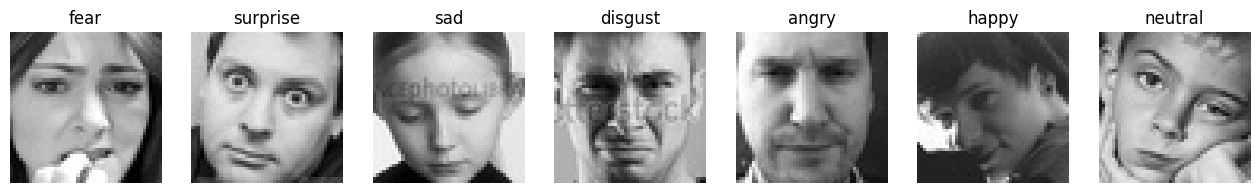

In [7]:
# Displaying images.
plt.figure(figsize=(16, 16))
i = 1
for expression in os.listdir(train_dir):
    img_path = os.path.join(train_dir, expression, os.listdir(os.path.join(train_dir, expression))[1])
    img = load_img(img_path)
    plt.subplot(1, 7, i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

/tmp/ipython-input-2431555607.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=class_counts, palette="viridis")  # Adjust the palette as needed


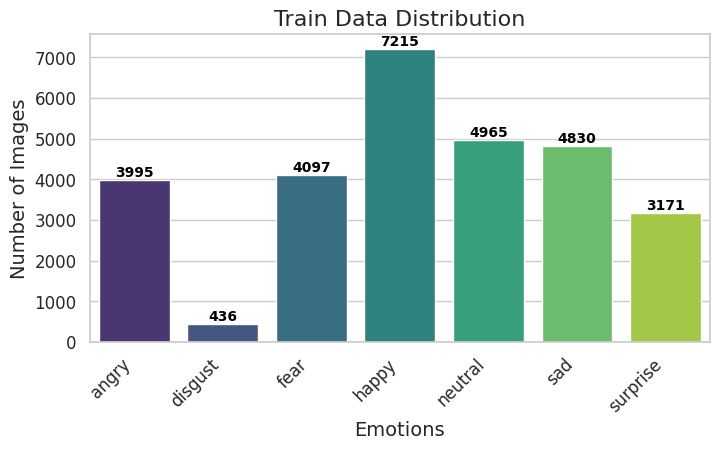

In [8]:
class_counts = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)]
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Set the seaborn style
sns.set(style="whitegrid", palette="pastel")

# Create a bar plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x=class_names, y=class_counts, palette="viridis")  # Adjust the palette as needed

# Add count annotations on top of the bars
for i, count in enumerate(class_counts):
    ax.text(i, count + 10, str(count), ha='center', va='bottom', fontweight='bold', color='black', size=10)

# Customize the plot
plt.xlabel('Emotions', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Train Data Distribution', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**CNN architectures**

**DenseNet-121** has densely connected layers, which allow each layer to access features from all previous layers.

**Pros:** Very accurate, generalizes well, good for complex datasets.

**Cons:** Resource-intensive and slower to train.

**Implementation:**

Feature extraction using pre-trained DenseNet121.

Classification head with fully connected layers and dropout for regularization.

Training includes freezing DenseNet layers first, then fine-tuning by unfreezing layers and reducing learning rate.

Performance is tracked via accuracy/loss curves, confusion matrices, and ROC curves.

---



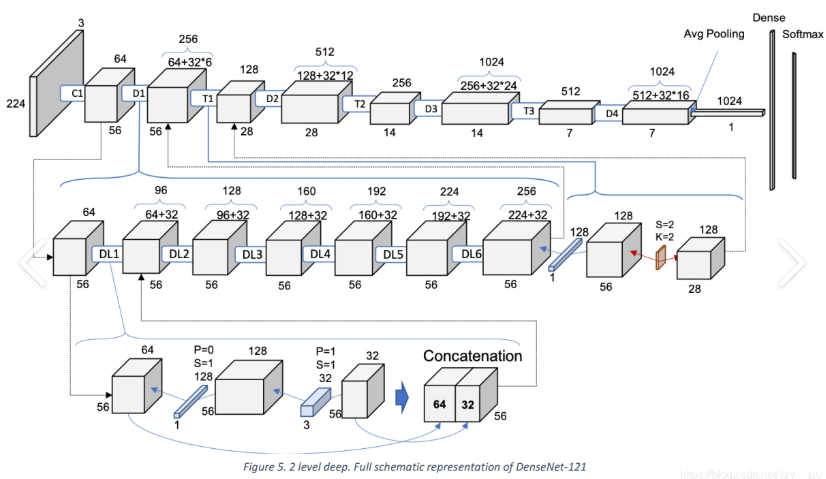

The code defines a Convolutional Neural Network (CNN) for image classification using the DenseNet121 architecture. It employs a modular design with three functions: feature_extractor, which initializes DenseNet121 as the backbone for feature extraction; classifier, which builds the classification head; and final_model, which integrates both components into the complete network. The model is compiled with stochastic gradient descent (SGD) as the optimizer, categorical crossentropy as the loss function, and accuracy as the evaluation metric. It processes input images of size (48, 48, 3) and outputs class probabilities across the defined number of categories (NUM_CLASSES).

In [9]:

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 128
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA = 3
CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

In [10]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet121(
        input_shape=(48, 48, 3),
        include_top=False,
        weights="imagenet")(inputs)   #loads useful pre-trained knowledge instead of random initialization.

    return feature_extractor

In [11]:

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)

    return x

In [12]:
def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)

    return classification_output

In [13]:
def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(48, 48, 3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    model.compile(
        optimizer=tf.keras.optimizers.SGD(0.1),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

**Model Compilation and Freezing Layers**

The define_compile_model() function creates and compiles the model using the SGD optimizer, categorical crossentropy loss, and accuracy as the evaluation metric. Initially, the DenseNet121 feature extraction layers are frozen by setting model.layers[1].trainable = False, ensuring that only the custom classifier layers are trained. A summary of the model architecture is then displayed.

**Training with Early Stopping**

The model is trained on the training set (train_generator) for 30 epochs, with validation on the validation set (validation_generator). An EarlyStopping callback is applied to monitor the validation loss and stop training if no improvement is observed after a defined patience (EARLY_STOPPING_CRITERIA). The callback also restores the best-performing weights.

**Fine-Tuning**

After the initial training, the DenseNet121 layers are unfrozen (model.layers[1].trainable = True) to enable fine-tuning of the entire network. The model is then recompiled with a smaller learning rate (0.001) and momentum (0.9) to allow for more precise weight updates. Fine-tuning is performed for an additional number of epochs (FINE_TUNING_EPOCHS), again with early stopping, and the training history is stored in the history_ variable.

In [ ]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOPPING_CRITERIA,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    x=train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[earlyStoppingCallback]
)

history = pd.DataFrame(history.history)

model.layers[1].trainable = True

model.compile(
    optimizer=tf.keras.optimizers.SGD(0.001, 0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_ = model.fit(
    x=train_generator,
    epochs=FINE_TUNING_EPOCHS,
    validation_data=validation_generator,
    callbacks=[earlyStoppingCallback],
)


x = px.line(data_frame=history, y=["accuracy", "val_accuracy"], markers=True)
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title="Accuracy")
x.update_layout(
    showlegend=True,
    title={
        'text': 'Accuracy vs Number of Epochs',
        'y': 0.94,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

x = px.line(data_frame=history, y=["loss", "val_loss"], markers=True)
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title="Loss")
x.update_layout(
    showlegend=True,
    title={
        'text': 'Loss vs Number of Epochs',
        'y': 0.94,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.3109 - loss: 6.6997 - val_accuracy: 0.3527 - val_loss: 4.1716
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 225s 996ms/step - accuracy: 0.3239 - loss: 3.7548 - val_accuracy: 0.3499 - val_loss: 2.7230
Epoch 4/30
166/225 ━━━━━━━━━━━━━━━━━━━━ 55s 941ms/step - accuracy: 0.3271 - loss: 2.5890